<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand.jpg" align="left">
</div>
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM - UEBA: Detección de Anomalías</p>
<p style="margin: 0; text-align:right;">20231 - Máster universitario en Ciencias de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicaciones</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos:</strong> Alejandro Ortega de los Ríos
</div>

# Extracción de características - Logon

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [27]:
logon_df = pd.read_csv('../data/logon.csv')
features = pd.read_csv('features.csv')

In [3]:
logon_df.head()

,id,date,user,pc,activity
0,{X1D9-S0ES98JV-5357PWMI},01/02/2010 06:49:00,NGF0157,PC-6056,Logon
1,{G2B3-L6EJ61GT-2222RKSO},01/02/2010 06:50:00,LRR0148,PC-4275,Logon
2,{U6Q3-U0WE70UA-3770UREL},01/02/2010 06:53:04,LRR0148,PC-4124,Logon
3,{I0N5-R7NA26TG-6263KNGM},01/02/2010 07:00:00,IRM0931,PC-7188,Logon
4,{D1S0-N6FH62BT-5398KANK},01/02/2010 07:00:00,MOH0273,PC-6699,Logon


In [4]:
insiders_list = features[features['insider'] == 1]['user'].tolist()

In [5]:
num_rows = len(logon_df)
num_insider_rows = len(logon_df[logon_df['user'].isin(insiders_list)])

print("Number of rows: {}".format(num_rows))
print("Number of insider rows: {} ({}%)".format(num_insider_rows, np.round(num_insider_rows/num_rows * 100), 1))

Number of rows: 854859
Number of insider rows: 49527 (6.0%)


In [6]:
print("Number of users: ", len(logon_df['user'].unique()))

Number of users:  1000


## 1. Número de inicios de sesión al día

In [7]:
# Obtengo fecha sin hora
logon_df['date_cleaned'] = pd.to_datetime(logon_df['date'], format='%m/%d/%Y %H:%M:%S').dt.date

# Agrupo los datos por usuario y día, y calculo el número de inicios de sesión por día para cada usuario
average_logins_per_day = logon_df.groupby(['user', 'date']).size().groupby('user').mean()

In [8]:
average_logins_per_day[average_logins_per_day > 1] 

user
KCF0045    1.000360
TSM0363    1.000358
dtype: float64

## 2. Duración de la sesión

In [9]:
#Organizo el dataset en registros actividad por usuario
logon_df.sort_values(by=['user', 'date', 'activity'], inplace=True)
logon_df = logon_df.reset_index()

In [10]:
#Sesiones diarias
logon_df = logon_df.rename(columns={'date':'logon_date'})
logon_df['logoff_date'] = logon_df.groupby('user').apply(lambda x: x['logon_date'].shift(-1) 
                                             if x['activity'].iloc[0] == 'Logon' else None).reset_index()['logon_date']

In [11]:
#Calculo si existen logon posteriores a logoff
logon_df['logoff_date'] = pd.to_datetime(logon_df['logoff_date'], format='%m/%d/%Y %H:%M:%S')
logon_df['logon_date'] = pd.to_datetime(logon_df['logon_date'], format='%m/%d/%Y %H:%M:%S')

err_duration = logon_df[(logon_df['logoff_date'] < logon_df['logon_date']) & (logon_df['activity'] == 'Logon')]
num_err_duration = len(err_duration)
num_err_duration_insiders = len(err_duration[err_duration['user'].isin(insiders_list)])

print("Number of sessions without logoff: {} ({}%)".format(num_err_duration, np.round(num_err_duration / num_rows * 100, 2)))
print("Number of insider sessions without logoff: {} ({}%)".format(num_err_duration_insiders, 
                                                             np.round(num_err_duration_insiders / num_insider_rows * 100, 2)))

Number of sessions without logoff: 288 (0.03%)
Number of insider sessions without logoff: 10 (0.02%)


In [12]:
#Calculo la duración de cada sesión
logon_df['duration'] =  logon_df['logoff_date'] - logon_df['logon_date']
logon_df.loc[logon_df['activity'] == 'Logoff', 'duration'] = pd.NA

In [13]:
#Convierto la duración en horas
logon_df['duration'] = logon_df['duration'].dt.total_seconds() / 3600

#Filtro las sesiones tengan una duración positiva
logon_df_cleaned = logon_df[logon_df['duration'] >= 0]

In [14]:
#Calculo si existen logon de más de 24h
err_duration = logon_df_cleaned[logon_df_cleaned['duration'] >= 24]
num_err_duration = len(err_duration)
num_err_duration_insiders = len(err_duration[err_duration['user'].isin(insiders_list)])

print("Number of sessions longer than 24h: {} ({}%)".format(num_err_duration, np.round(num_err_duration / num_rows * 100, 2)))
print("Number of insider sessions longer than 24h: {} ({}%)".format(num_err_duration_insiders, 
                                                             np.round(num_err_duration_insiders / num_insider_rows * 100,3)))

Number of sessions longer than 24h: 251 (0.03%)
Number of insider sessions longer than 24h: 0 (0.0%)


In [15]:
logon_df_cleaned = logon_df_cleaned[logon_df_cleaned['duration'] < 24]

In [16]:
#Obtengo día de la semana
logon_df_cleaned['weekday'] = pd.to_datetime(logon_df['logon_date']).dt.weekday

#Filtro por días laborables y festivos
weekday_logon = logon_df_cleaned[(logon_df_cleaned['weekday'] != 5) & (logon_df_cleaned['weekday'] != 6)]
weekend_logon = logon_df_cleaned[(logon_df_cleaned['weekday'] == 5) | (logon_df_cleaned['weekday'] == 6)]

C:\Users\alexo\AppData\Local\Temp\ipykernel_1164\3554076189.py:20: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  axes[1].hist(weekend_duration[weekend_insiders], edgecolor='black', color='green', alpha=0.7, density=True, label='Insider')


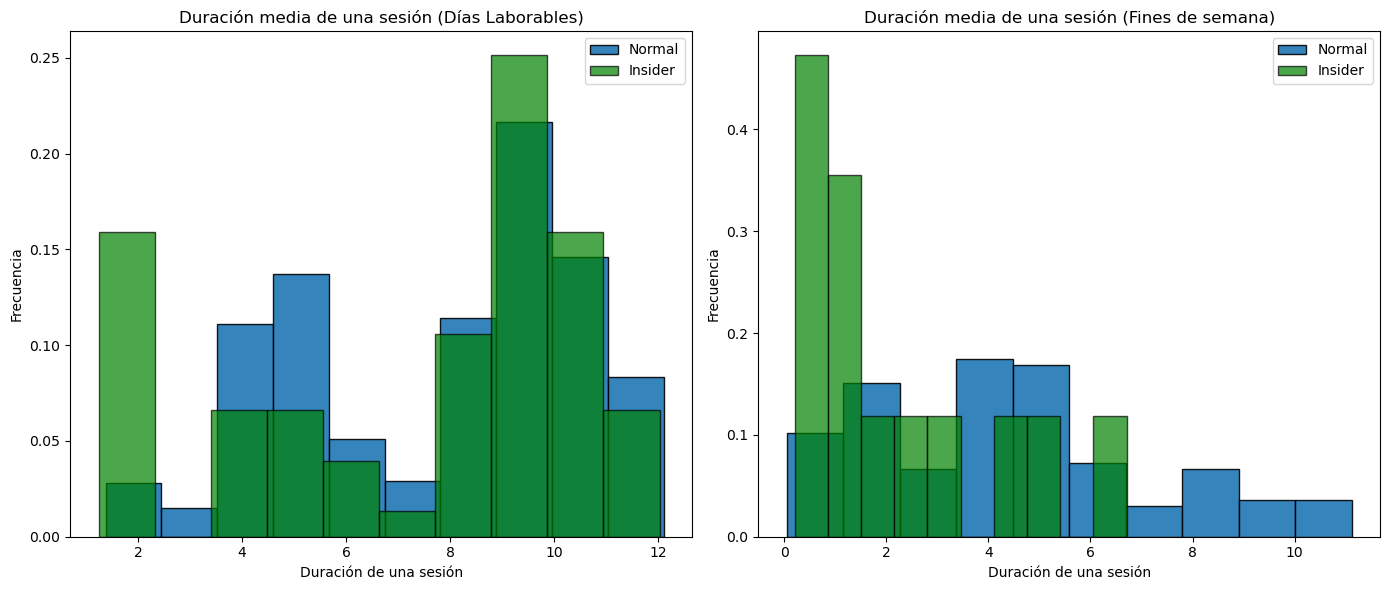

In [17]:
#Divido entre usuario normal e insider
weekday_duration = weekday_logon[weekday_logon['activity'] == 'Logon'].groupby('user')['duration'].mean()
weekend_duration = weekend_logon[weekend_logon['activity'] == 'Logon'].groupby('user')['duration'].mean()

#Obtengo los insiders que inician sesión los fines de semana
weekend_insiders = set(weekend_duration.index.tolist()) & set(insiders_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

#Genero histograma para días laborables
axes[0].hist(weekday_duration[~weekday_duration.index.isin(insiders_list)], edgecolor='black', alpha=0.9, density=True, label='Normal')
axes[0].hist(weekday_duration[insiders_list], edgecolor='black', color='green', alpha=0.7, density=True, label='Insider')
axes[0].set_xlabel('Duración de una sesión')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Duración media de una sesión (Días Laborables)')
axes[0].legend()

#Genero histograma para días festivos
axes[1].hist(weekend_duration[~weekend_duration.index.isin(weekend_insiders)], edgecolor='black', alpha=0.9, density=True, label='Normal')
axes[1].hist(weekend_duration[weekend_insiders], edgecolor='black', color='green', alpha=0.7, density=True, label='Insider')
axes[1].set_xlabel('Duración de una sesión')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Duración media de una sesión (Fines de semana)')
axes[1].legend()


plt.tight_layout()
plt.show()

## 2. Espacio de Características

In [18]:
users = logon_df['user'].unique().tolist()

In [19]:
#Creo un diccionario a partir de weekday/weekend_duration
weekend_duration_dict = weekend_duration.to_dict()
weekday_duration_dict = weekday_duration.to_dict()

In [20]:
#Obtengo horas de logon/logoff
logon_hours = logon_df['logon_date'].dt.hour + (logon_df['logon_date'].dt.minute / 60)
logoff_hours = logon_df['logoff_date'].dt.hour + (logon_df['logoff_date'].dt.minute / 60)

# Reemplazo valor nan en logoff por la hora media de logoff
logoff_mean = np.nanmean(logoff_hours)
logoff_hours = logoff_hours.fillna(logoff_mean)

#Creo diccionario de horas inicio/fin de sesión
logon_hours_dict = dict(zip(logon_df['user'], logon_hours))
logoff_hours_dict = dict(zip(logon_df['user'], logoff_hours))

In [21]:
# Asigno los valores correspondientes si el usuario existe en weekend_emails, y cero en caso contrario
features['weekend_duration'] = features['user'].map(weekend_duration_dict).fillna(0)
features['weekday_duration'] = features['user'].map(weekday_duration_dict).fillna(0)
features['logon_hour'] = features['user'].map(logon_hours_dict)
features['logoff_hour'] = features['user'].map(logoff_hours_dict)

In [29]:
features.to_csv('features.csv')